# Angelo

Notebook iterating gamma. I use this to generate experimental phases used for the analysis.

### Imports

In [1]:
from XRDXRFutils import Phase,DatabaseXRD, DataXRF, DataXRD, SpectraXRD, GaussNewton, PhaseList, PhaseMap, PhaseSearch, PhaseMapSave
from XRDXRFutils import GammaMap,ChiMap

import os
import pickle


from joblib import Parallel, delayed
import h5py
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit, least_squares

from numpy import linspace,concatenate,sqrt,log,histogram,array,unravel_index
from matplotlib.pyplot import sca,vlines,show,fill_between,sca,legend,imshow,subplots,plot,xlim,ylim,xlabel,ylabel,cm,title,scatter,colorbar,figure,vlines
from sklearn.cluster import KMeans,MiniBatchKMeans

from multiprocessing import Pool

from PIL import Image

def f_linear(x,a,b):
    return a*x + b
def f_loss(x,t,y):
    return (x[0]*t + x[1]) - y

#### Define Paths and Spectra Parameters

In [2]:
path_xrd = '/home/shared/dataXRDXRF/Perugia/PieroDellaFrancesca/Cimasa/AngeloXRD/' # XRD scan
path_xrf = '/home/shared/dataXRDXRF/Perugia/PieroDellaFrancesca/Cimasa/AngeloXRF/' # XRF scan
path_database = '/home/shared/DatabaseXRD'

path_data = 'data/' # data of intermediate results, for fast loading
path_figures = 'figures/' # figures generated by the script
path_results = 'results/' # results generated by the script: raw data, tif maps

min_theta = 20
max_theta = 58
min_intensity = 0.1 # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = None # selects the first n most intense peaks (if None, leaves all the peaks)

sigma = 0.2

## Read XRD Data

from xrd.h5

Loading: /home/shared/dataXRDXRF/Perugia/PieroDellaFrancesca/Cimasa/AngeloXRD/xrd.h5
a: -1172.8 s: 2053.1 beta: 50.710


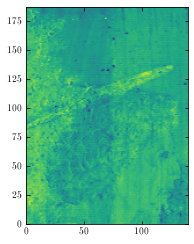

In [3]:
try:
    data = DataXRD().load_h5(path_xrd + 'xrd.h5')
except:
    print('Reading from raw data.')
    data = DataXRD().read_params(path_xrd + 'Scanning_Parameters.txt').read(path_xrd).calibrate_from_file(path_xrd + 'calibration.ini').remove_background().save_h5(path_xrd + 'xrd.h5')
    
print("a: %.1f s: %.1f beta: %.3f"%(data.opt[0],data.opt[1],data.opt[2]))

figure(figsize=(6,4))
im = imshow(data.data.sum(axis=2))
show()

# Display XRF

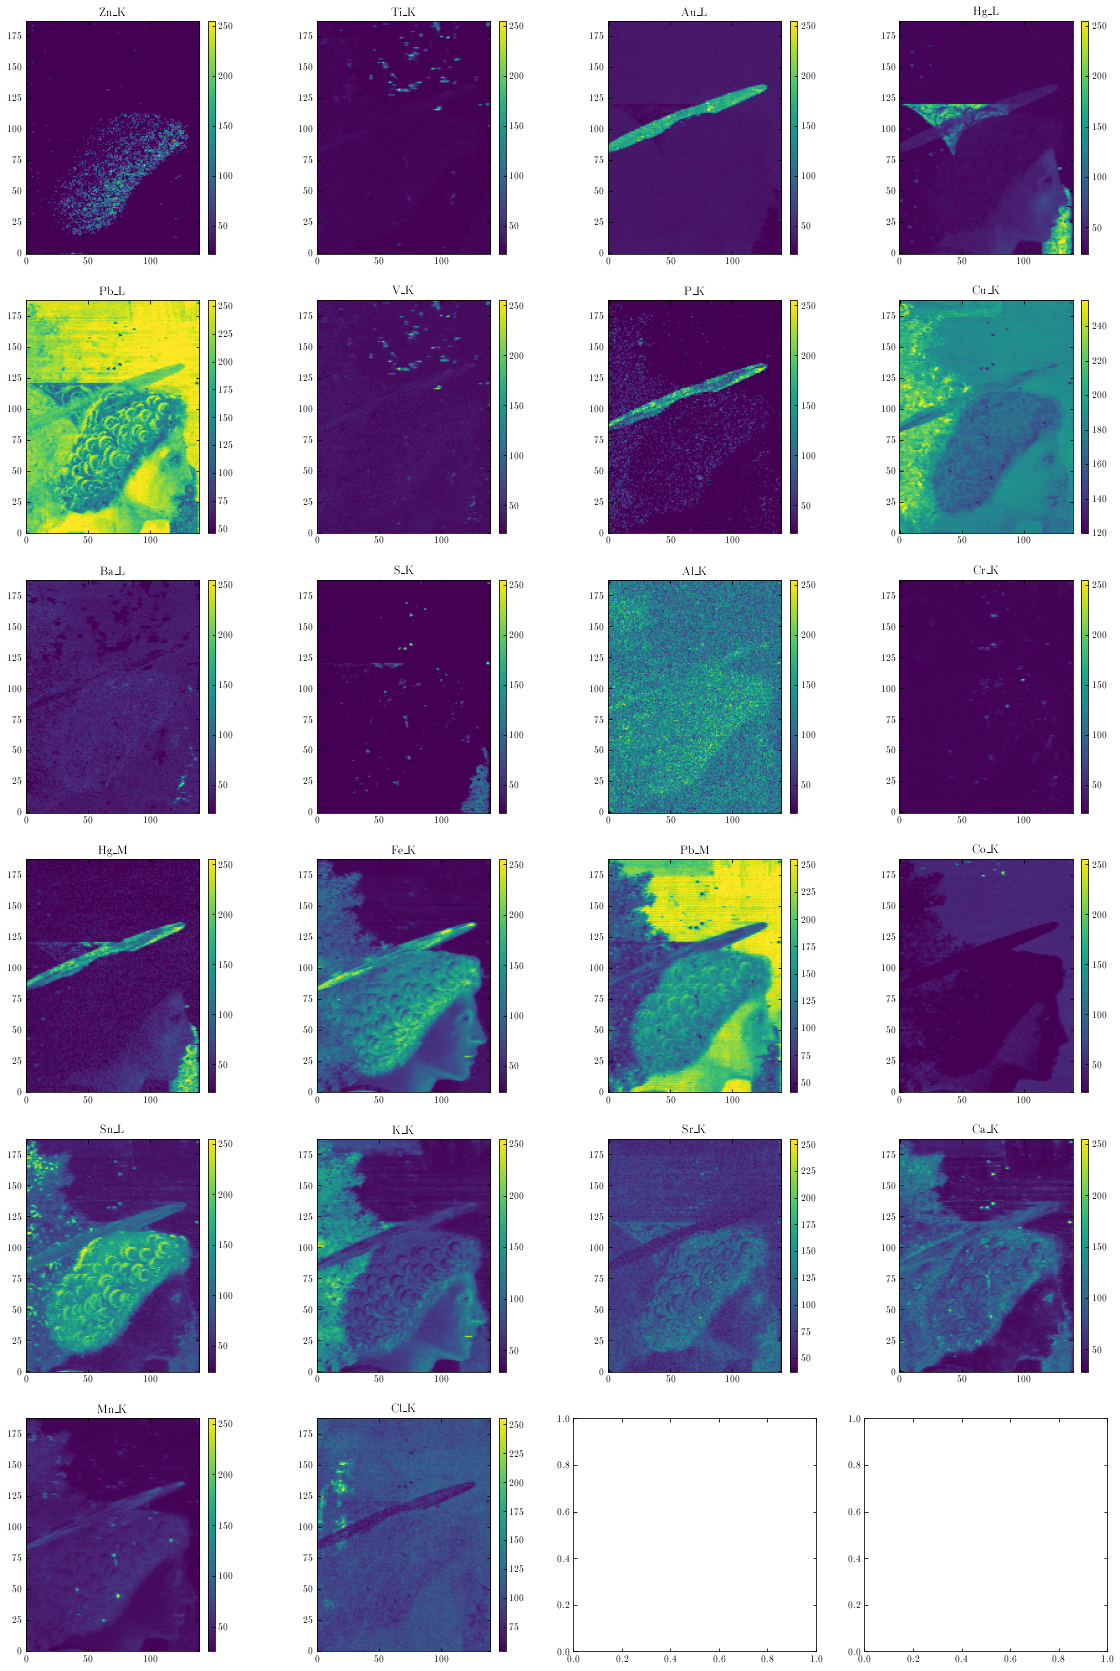

In [4]:
%matplotlib inline

data_xrf = DataXRF()
data_xrf.read_tiff(path_xrf)
data_xrf.labels = data_xrf.labels[::-1]

n_of_columns = 4

n_of_pictures = len(data_xrf.metadata['labels'])
n_of_rows = n_of_pictures // n_of_columns

if (n_of_pictures % n_of_columns):
    n_of_rows += 1

fig, ax = subplots(n_of_rows, n_of_columns, figsize = (5 * n_of_columns, 5 * n_of_rows))
for i, label in enumerate(data_xrf.metadata['labels']):
    
    i_row = i // n_of_columns
    i_column = i % n_of_columns
    
    iax = ax[i_row, i_column]
    im = iax.imshow(data_xrf.labels[..., i])
    colorbar(im, ax = iax, cax = iax.inset_axes([1.05, 0, 0.04, 1]))
    
    iax.set_title(label)
    
show()

## Read database

This is for simplification. Phases can be selected iteratively from database using 'Tab'

In [5]:
database = DatabaseXRD().read_cifs(path_database)

print('Phases in database:',len(database))

lazurite = database['Lazurite'][0]
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][1]
barite = database['Barite'][0]
spinel = database['Spinel'][0]
calcite = database['Calcite'][0]
hematite = database['Hematite'][4]
gold = database['Gold'][0]

huntite = database['Huntite'][0]
as4 = database['As4 O6'][0]

orpiment = database['Orpiment'][0]
cuprorivaite = database['Cuprorivaite'][0]

phases = PhaseList([hydrocerussite, cinnabar, lazurite, gold, hematite])

phases.get_theta(min_intensity=min_intensity,
                 min_theta = min_theta,
                 max_theta = max_theta,
                first_n_peaks = first_n_peaks)

if 'pmax_a' in locals():
    data.opt[0] = p_a
    data.opt[1] = p_s

Phases in database: 137


# Search database

In [6]:
elements_chosen = ['Fe']

for v,k in sorted(database.items()):
    p = k[0]
    if '_chemical_formula_sum' in p:
        if all(e in p['_chemical_formula_sum'] for e in elements_chosen):
            if '_chemical_name_mineral' in p:
                print(p['_chemical_name_mineral'] + ', ', end = '\t')
            print(p['_chemical_formula_sum'] + ', ', end = '\t')
            print(len(k))

Akaganeite, 	Cl0.675 Fe4 O8, 	2
Erythrite, 	As4 Co4.02 Fe1.48 H32 Ni0.50 O32, 	1
Fe H O2, 	1
Fe2 Mn O4, 	4
Fe2 O3, 	12
Goethite, 	Fe H O2, 	21
Hematite, 	Fe2 O3, 	10
Jacobsite, 	Al0.049 Fe1.911 Mg0.736 Mn0.284 O4 Zn0.017, 	4
Jarosite, 	Fe2.88 H5.83 K0.81 O13.64 S2, 	15
Lepidocrocite, 	Fe H O2, 	2
Magnetite, 	Fe3 O4, 	1
Pyrite, 	Fe S2, 	9
Siderite, 	C Fe O3, 	2
Wuestite, 	Fe0.911 O, 	11


# Plot XRF of selected element

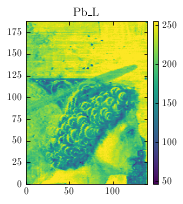

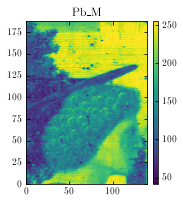

In [7]:
element_chosen = 'Pb'

for i,label in enumerate(data_xrf.metadata['labels']):
    if element_chosen + '_' in label:
        fig, ax  = subplots(figsize=(5,3))
        
        title(label)
        im = imshow(data_xrf.labels[..., i])
        colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))

show()

In [8]:
%%time
pm = GammaMap().from_data(data,phases,sigma = sigma)

CPU times: user 2.27 s, sys: 196 ms, total: 2.47 s
Wall time: 2.47 s


### Autocalibration and Search
Iterates $a,s$ and $\gamma$. Choses the best phase by overlap area and fits with respect to that.

In [9]:
%%time
pm = pm.search()

Using 50 cpu
CPU times: user 27.8 s, sys: 4.67 s, total: 32.5 s
Wall time: 49.5 s


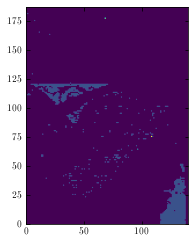

In [10]:
map_selected = pm.selected()
imshow(map_selected[...,0])
show()

In [11]:
%%time
L1loss,MSEloss,overlap_area = pm.metrics()
rescaling = data.rescaling
criterium = overlap_area * rescaling**0.5

Using 50 cpu
CPU times: user 4.18 s, sys: 1.85 s, total: 6.03 s
Wall time: 7.67 s


### Histogram of $a$

If $a$ is spead over too large area it might be that the phases are to right or a phase is missing

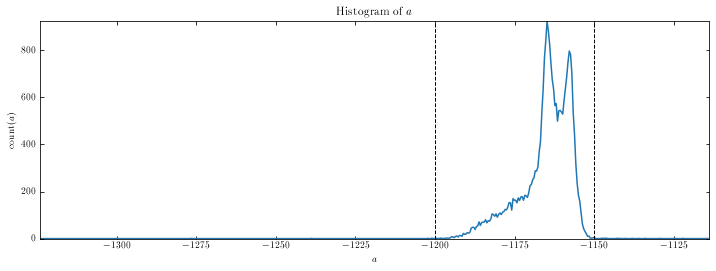

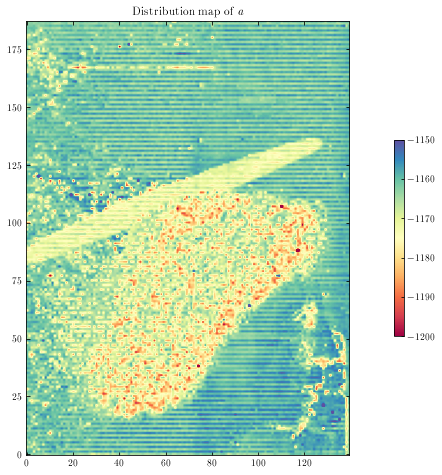

In [12]:
%matplotlib inline

opt = pm.opt()
a = opt[...,0]
s = opt[...,1]

vmin = -1200
vmax = -1150

h,b = histogram(a,bins=512)

figure(figsize=(12,4))

plot(b[:-1],h)
xlim(b[0],b[-1])
ylim(0,h.max())

vlines(vmin,0,h.max(),'k',ls='--',lw=1)
vlines(vmax,0,h.max(),'k',ls='--',lw=1)

xlabel('$a$')
ylabel(r'count($a$)')
title(r'Histogram of $a$')

figure(figsize=(16,8))
title('Distribution map of $a$')
im = imshow(a,cmap='Spectral',vmin=vmin,vmax=vmax)
colorbar(im,fraction=0.011)

show()

## Plotting the $a,s$ dependence

There is a slight notion of a second $as$ dependence but it is weak.

Linear: [   -2.8939739 -1314.4202855]
Cauchy: [   -3.05572774 -1500.13736862]
mean a,s: -1165.0225835677406 2057.1246659503136
most probable a,s: -1164.811147273745 2059.208363144602


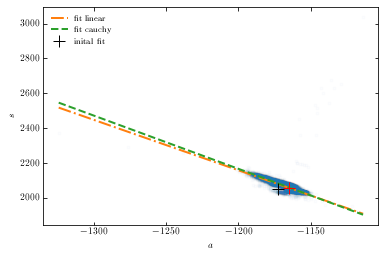

In [13]:
%matplotlib inline

opt,var = curve_fit(f_linear,a.flatten(),s.flatten())
res = least_squares(f_loss,x0=opt,args=(a.flatten(),s.flatten()),loss='cauchy')

linear_y = f_linear(a.flatten(),*opt)
cauchy_y = f_linear(a.flatten(),*res['x'])

print('Linear:',opt)
print('Cauchy:',res['x'])

plot(a.flatten(),s.flatten(),'.',alpha=0.01)

x = linspace(a.min(),a.max(),10)
plot(x,f_linear(x,*opt),'-.',lw=2,label='fit linear')
plot(x,f_linear(x,*res['x']),'--',lw=2,label='fit cauchy')
plot(data.opt[0],data.opt[1],'k+',ms=12,label='inital fit')

print('mean a,s:',a.mean(),s.mean())

legend(frameon=False)

xlabel(r'$a$')
ylabel(r'$s$')

pmax_a = b[h.argmax()]
pmax_s = f_linear(pmax_a, *res['x'])

print('most probable a,s:',pmax_a,pmax_s)

plot(pmax_a,pmax_s,'r+',ms=12,label='most likely')

show()

### Criterium

Criterium for phase selection.

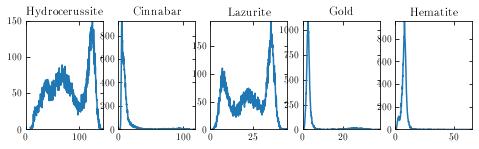

In [14]:
fig,ax = subplots(1,len(pm.phases),figsize=(8,2))

for i,phase in enumerate(pm.phases):
    ax[i].set_title(phase.label)
    h,b = histogram(criterium[:,:,i],bins=512)
    ax[i].plot(b[:-1],h)
    ax[i].set_xlim(0,b.max())
    ax[i].set_ylim(0,h.max())
    
show()

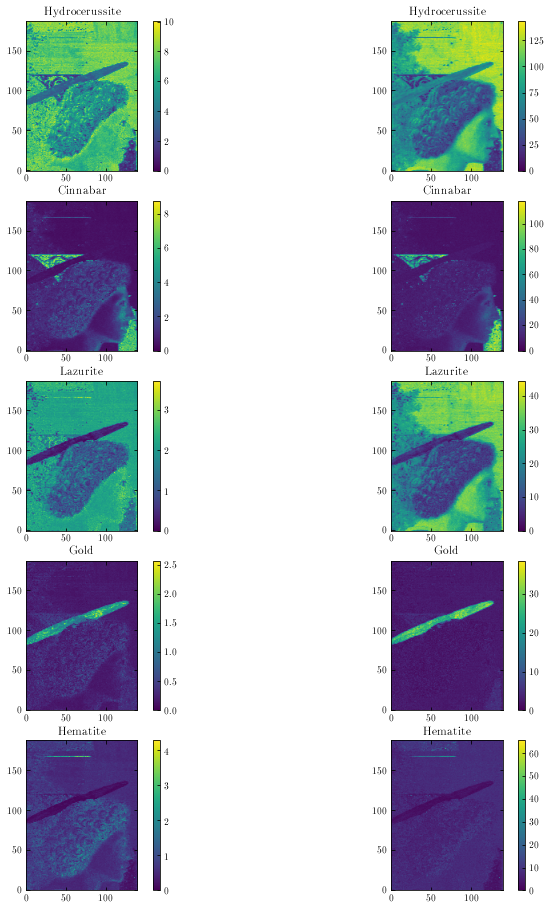

In [15]:
%matplotlib inline
fig,ax = subplots(len(pm.phases),2,figsize=(12,16))

for i,phase in enumerate(pm.phases):
    ax[i,0].set_title(phase.label)
    p = ax[i,0].imshow(overlap_area[...,i],vmin=0)
    colorbar(p,ax = ax[i,0])
    
    ax[i,1].set_title(phase.label)
    p = ax[i,1].imshow(criterium[...,i],vmin=0)
    colorbar(p,ax = ax[i,1])
    
show()

# Select experimental phases

In [16]:
new_phases = pm.select_phases(criterium,-4)
experimental_phases = PhaseList(new_phases)

Hydrocerussite (121, 159) [-1155.67420846  2033.68945654    50.71024216] 22381
Cinnabar (129, 10) [-1154.89246854  2031.52279689    50.71024216] 1529
Lazurite (34, 187) [-1148.10779454  2009.93671997    50.71024216] 26214
Gold (83, 118) [-1155.85786045  2025.96852569    50.71024216] 16603
Hematite (77, 167) [-1164.05293105  2005.11431564    50.71024216] 23457


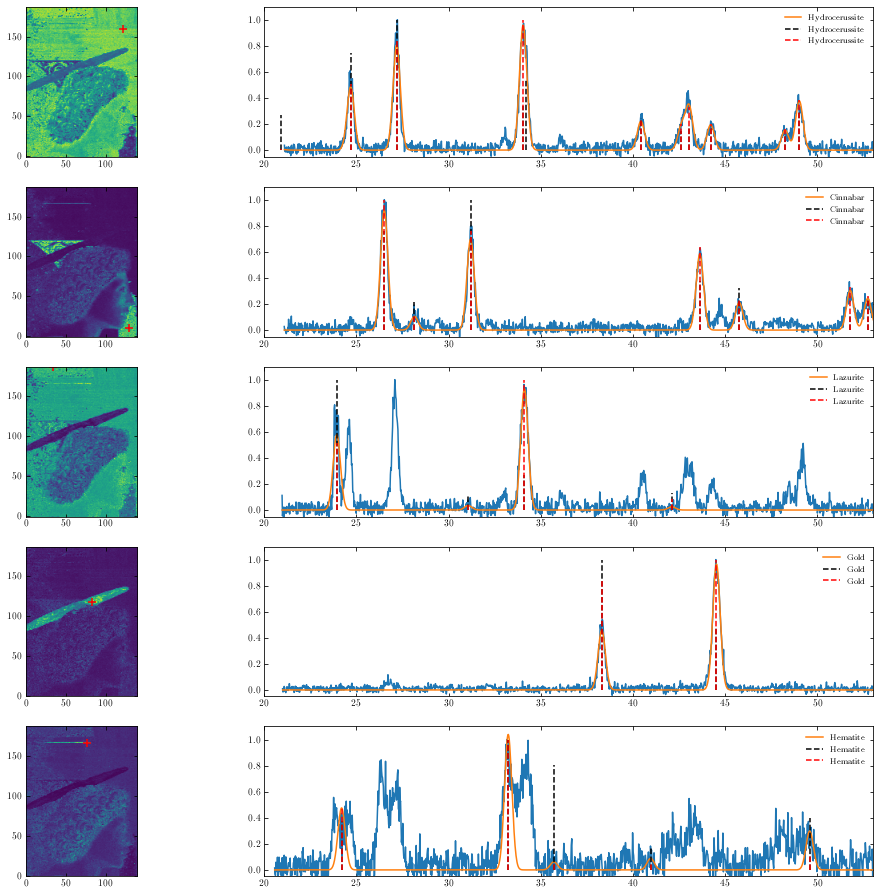

In [17]:
fig, ax = subplots(len(pm.phases),2,
                   figsize=(16,16),
                   gridspec_kw = {'width_ratios': [1, 3]})

for i,phase in enumerate(new_phases):
    
    point = phase['point']
    y,x = unravel_index(point,pm.shape[:2])

    sca(ax[i][0])
    imshow(overlap_area[...,i],vmin=0)
    scatter(x, y, s = 50, c = 'red',marker ='+')
    
    sca(ax[i][1])
    
    g = pm[point][i]
    g.fit_cycle(gamma=True,steps = 128,a=True,s=True)
    print(g.label,(x,y),g.opt,point)
    
    g.plot_spectrum()
    g.plot(label=g.label)
    
    g.phase.plot('k')
    phase.plot('r')
    
    xlim(20,53)
    ylim(-0.05,1.1)
    legend(frameon=False)

show()

# Save .cif files

In [ ]:
for phase in new_phases:
    name = 'AngeloDatabase/' + phase.label + '.cif'
    print(name)
    phase.save_cif(name)

## Interogate single pixel

[-1148.10779454  2009.93671997    50.71024216]


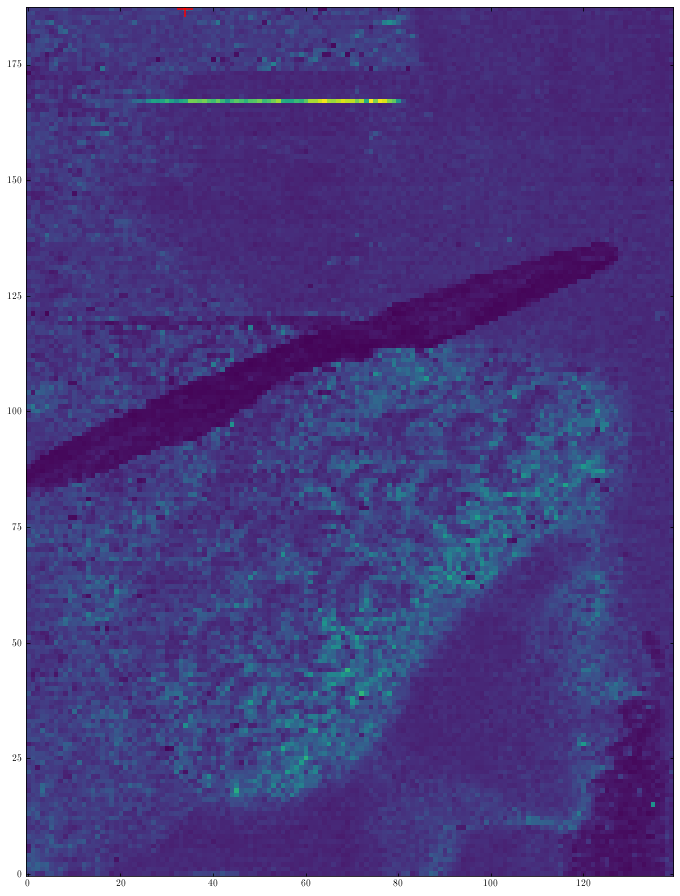

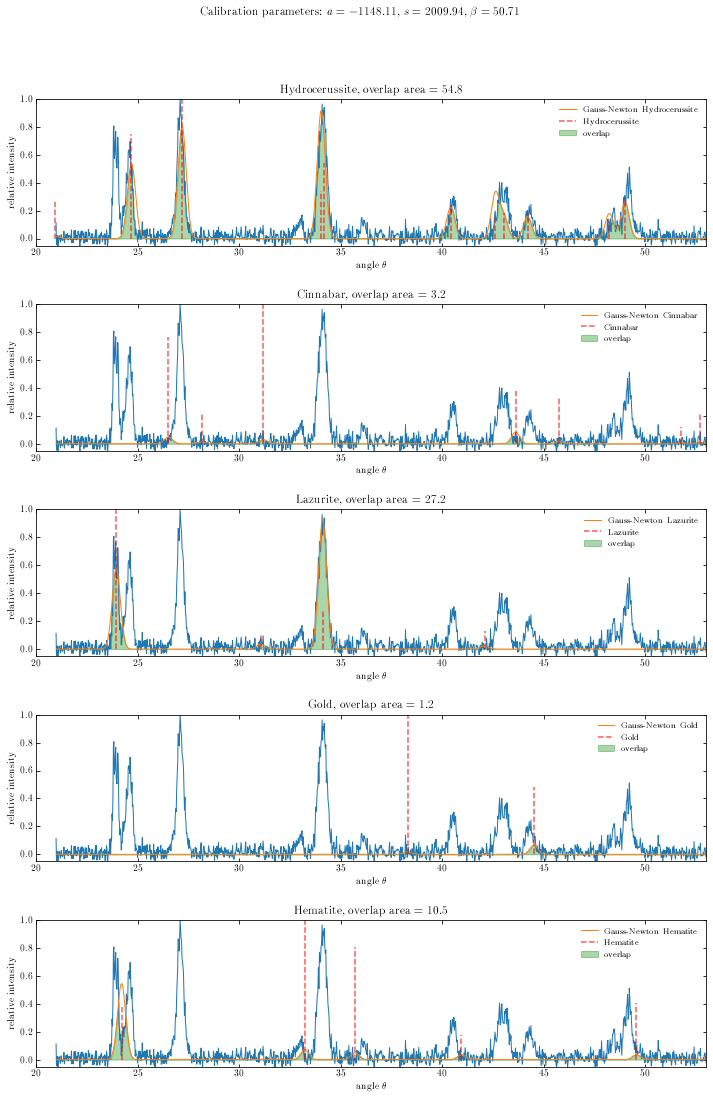

In [20]:
%matplotlib inline
x = 34
y = 187

selected = pm.get_pixel(x,y)

figure(figsize=(16,16))
imshow(overlap_area[...,i],vmin=0)
scatter(x, y, s = 256, c = 'red',marker ='+')

fig, axes = subplots(len(selected), 1, figsize = (12,16))
fig.subplots_adjust(hspace = 0.4, bottom = 0.06, top = 0.9)
print(selected.opt)

fig.suptitle(r'Calibration parameters: $a = %.2f$, $s=%.2f$, $\beta=%.2f$'%(selected.opt[0], selected.opt[1], selected.opt[2]))

for i in range(len(selected)):
    ax = axes[i]
    g = selected[i]
    sca(ax)

    ax.set_title(f'{g.label}, overlap area = {g.overlap_area():.1f}')
    g.plot_spectra(lw = 1)
    g.plot('-', label='Gauss-Newton %s'%g.label, lw=1)
    g.phase.plot('r', alpha=0.66)

    fill_between(g.theta.squeeze(), g.overlap(), color = 'g', alpha = 0.33, label='overlap')

    legend(frameon = False)
    ax.set_ylim(-0.05, 1)
    ax.set_xlim(20, 53)
    ax.set_xlabel(r'angle $\theta$')
    ax.set_ylabel(r'relative intensity')
    
show()

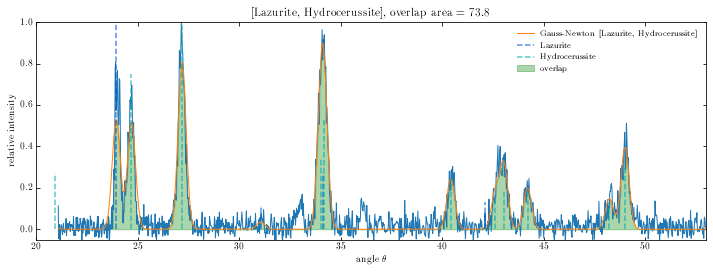

In [21]:
mix = PhaseList([lazurite,hydrocerussite])

g = GaussNewton(mix,selected.spectrum,sigma=sigma)

g.fit_cycle(gamma=True,steps = 128,a=True,s=True)

figure(figsize=(12,4))

title(f'{g.label}, overlap area = {g.overlap_area():.1f}')

g.plot_spectra(lw = 1)
g.plot('-', label='Gauss-Newton %s'%g.label, lw=1)
g.phase.plot(alpha=0.66)

fill_between(g.theta, g.overlap(), color = 'g', alpha = 0.33, label='overlap')

legend(frameon = False)

ylim(-0.05, 1)
xlim(20, 53)
xlabel(r'angle $\theta$')
ylabel(r'relative intensity')

show()

### Fit errrors

Plotting the histograms and maps of the error for each phase. 

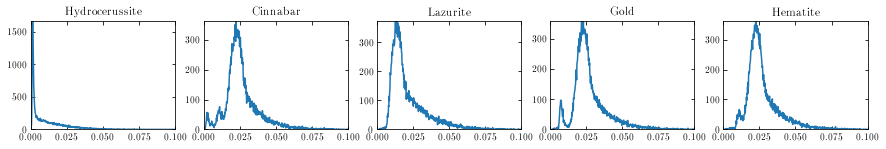

In [22]:
fig,ax = subplots(1,len(pm.phases),figsize=(15,2))

for i,phase in enumerate(pm.phases):
    ax[i].set_title(phase.label)
    h,b = histogram(MSEloss[:,:,i],bins=512,range=(0,0.1))
    ax[i].plot(b[:-1],h)
    ax[i].set_xlim(0,b.max())
    ax[i].set_ylim(0,h.max())
    
show()

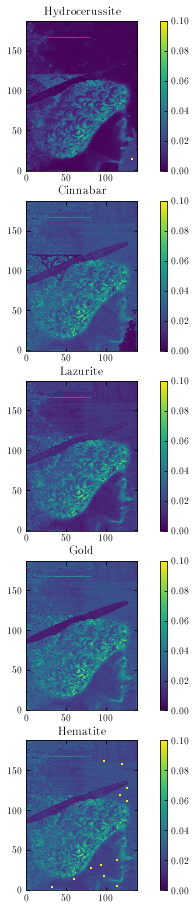

In [23]:
fig,ax = subplots(len(pm.phases),1,figsize=(8,16))

for i,phase in enumerate(pm.phases):
    ax[i].set_title(phase.label)
    p = ax[i].imshow(MSEloss[:,:,i],vmin=0,vmax= 0.1)
    p = colorbar(p,ax = ax[i],fraction=0.04)
    
show()